# CASE STUDY 3

KJ Price, Amber Whelpley, Festus Asare Yeboah

In this case study we attempt to create an automated way for  classifying email messages as being either spam or ham. 
To do this we employed naive bayes model to train a set of emails from a pool of 9000 messages that have been classified by SpamAssassin.
(http://spamassassin.apache.org)

The script that we used to clean the data set and get it ready for modelling   can be found [here](ReadSpamData_fromBook.R)

This notebook  is divided into 3 sections:

* ***Response questions from book***: My team chose to answer Q20 which comprises of 5 subquestions. The first sections contains our response.

* ***Graphs and Charts*** : Charts thats were used to understand the hidden raltionships and behaviors in the data are presented here

* ***Modelling***: This section contains the code we used to train and test the email classification model

If you would like to run the code in this notebook we recommend you the ran the last section ***Modelling*** before running any other section





## Responses from Book

#### (a) Use the sample() function to permute the indices of the training set, and organize these permuted indices into 5 equal-size sets, called folds.


In the code section  below we prepare the training data for a 5 fold cross validation. Each set of indices created  will be used to create a subset of the original training data. We then use one set as test data  and remaining set as training. We do this recursively till all the 5 set has been used as test set.

The evaluation score  for each itreation is averaged out to compute the over all effectiveness of our model

With cross validation we can significanlty reduce bias as it ensures that most of the data  is used for fitting, and also significantly reduces variance because it ensures a good portion of the traiing set is used for validation. 






In [21]:
indices = sample(1:length(trainMsgWords))

In [26]:
folds = as.list(split(indices, sort(indices%%5)))
fold_indices = names(folds)

#### (b) For each fold, take the corresponding subset from the training data to use as a ‘test’ set. Use the remaining messages in the training data as the training set. Apply the functions developed in Section 3.6 to estimate the probabilities that a word occurs in a message given it is spam or ham, and use these probabilities to compute the log likelihood ratio for the messages in the training set.


In [23]:
getLogLikelyhoodForEachFold <- function() {
    llr = list()
    for (i in 1:length(fold_indices)) {
        current_name = fold_indices[i]
        otherNames = fold_indices[fold_indices != current_name]

        test_indices = unlist(folds[current_name])
        train_indices = unlist(folds[otherNames])

        #testMsgWords_local = trainMsgWords[test_indices]
        trainMsgWords_local = trainMsgWords[train_indices]

        #testIsSpam_local = testIsSpam[test_indices]
        trainIsSpam_local = trainIsSpam[train_indices]

        trainTable_local = computeFreqs(trainMsgWords_local, trainIsSpam_local)


        newMsg = trainMsgWords_local[[1]]

        newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable_local)))]

        present = colnames(trainTable_local) %in% newMsg

        trainLLR_local = sapply(trainMsgWords_local, computeMsgLLR, trainTable_local)
        llr[[i]] = trainLLR_local
    }
    return(unlist(llr))
}

LLR = getLogLikelyhoodForEachFold()

#### (c) Pool all of the LLR values from the messages in all of the folds, i.e., from all of the training data, and use these values and the typeIErrorRate() function to select a threshold that achieves a 1% Type I error.


Incorrectly classifying emails that are ham as spam means we loose important emails to the junk folder  in messaging applications. This is referred to as false positive or type 1 error. In order to minimize the effect of type 1 error we employ the  custom function typeIErrorRate
function to set a threshold for deciding whether a message is ham or spam

In [27]:
# -47 threshold gives us approximately a 1% type 1 error
typeIErrorRate(-47, LLR, getIsSpamFolds())

[1] 0.01062797

#### (d) Apply this threshold to our original/real test set and find its Type I and Type II errors.


In [28]:
# type 1 errors: 5.4%
# type 2 errors: 15.6%

sum(predsForHam == "T") / length(predsForHam)

predsForSpam = predictions[ testDF$isSpam == "T" ]
sum(predsForSpam == "F") / length(predsForSpam)

complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19), 
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

[1] 0.05394907

[1] 0.1564456

In [28]:
typeIErrorRate(-47, testLLR, testIsSpam)

[1] 0.011653

In [29]:
# I don't think this function existed so I went ahead and created it - using typeIErrorRate as my muse
typeIIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(!classify & spam)/sum(spam)
}


In [30]:
typeIIErrorRate(-47, testLLR, testIsSpam)

[1] 0.0175219

## GRAPHS AND CHARTS

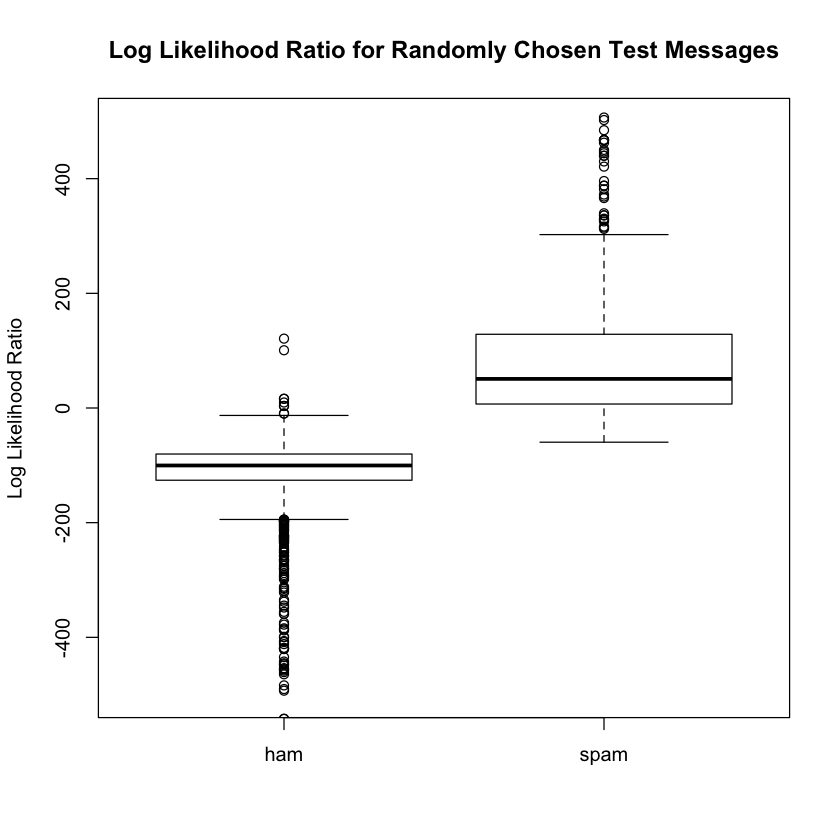

In [38]:
spamLab = c("ham", "spam")[1 + testIsSpam]
boxplot(testLLR ~ spamLab, ylab = "Log Likelihood Ratio",
        main = "Log Likelihood Ratio for Randomly Chosen Test Messages",
        ylim=c(-500, 500))

From the graph above we noticed that most ham messages have negative values and  nearly all spam values are positive. 
In addtion to that we noticed more compactness in the ham box plot that proves less variablitly in ham classification. 
This behvior seen here  makes prediction of ham very dependable shows a clear distinction between spam and ham messages.

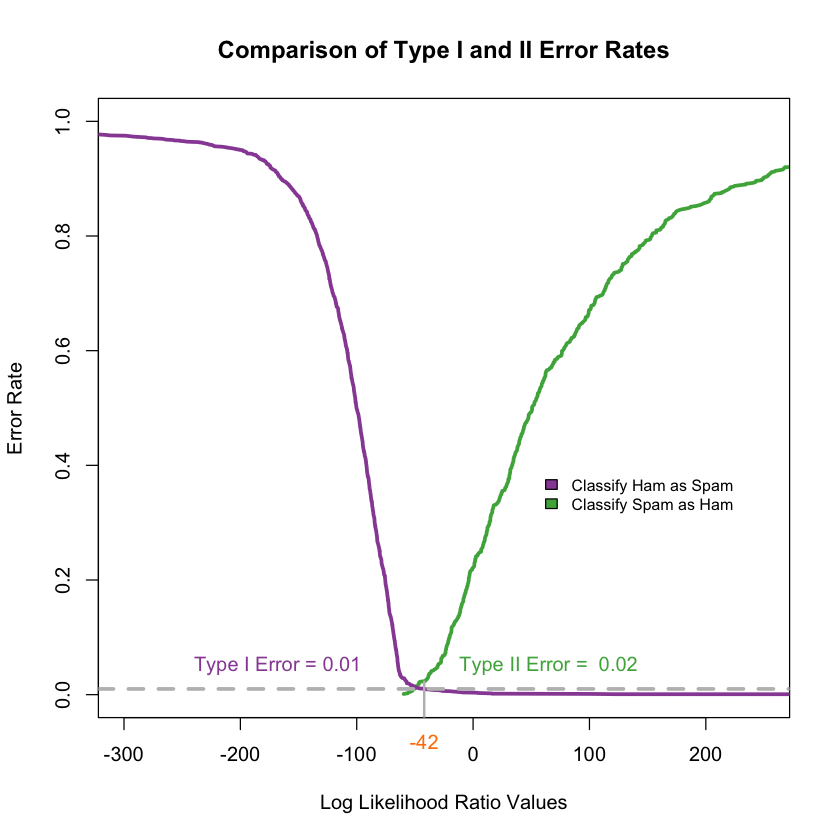

In [19]:
# plot error rates for spam and ham misclassification
# showing that tau is optimized where type 1 and 2 errors at their minimums

library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(xII$error ~ xII$values,  type = "l", col = cols[1], lwd = 3,
     xlim = c(-300, 250), ylim = c(0, 1),
     xlab = "Log Likelihood Ratio Values", ylab="Error Rate",main = "Comparison of Type I and II Error Rates")
points(xI$error ~ xI$values, type = "l", col = cols[2], lwd = 3)
legend(x = 50, y = 0.4, fill = c(cols[2], cols[1]),
       legend = c("Classify Ham as Spam", 
                  "Classify Spam as Ham"), cex = 0.8,
       bty = "n")
abline(h=0.01, col ="grey", lwd = 3, lty = 2)
text(-250, 0.05, pos = 4, "Type I Error = 0.01", col = cols[2])

mtext(tau01, side = 1, line = 0.5, at = tau01, col = cols[3])
segments(x0 = tau01, y0 = -.50, x1 = tau01, y1 = t2, 
         lwd = 2, col = "grey")
text(tau01 + 20, 0.05, pos = 4,
     paste("Type II Error = ", round(t2, digits = 2)), 
     col = cols[1])

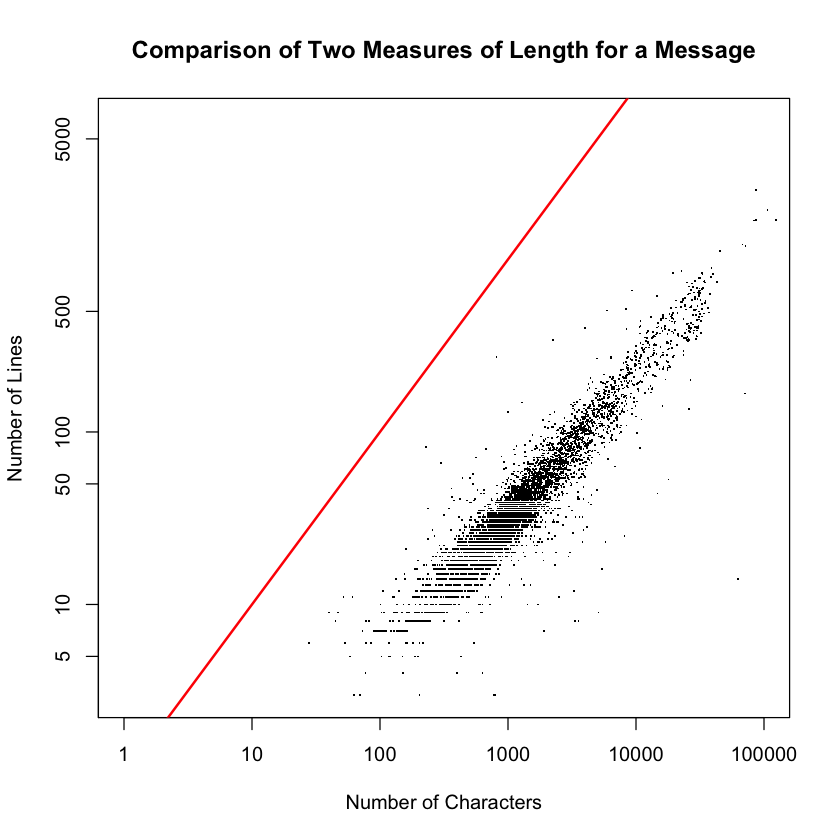

In [20]:
# plot that shows the # of characters and lines in the body of the emails. 
# they are positively correlated

plot(nL ~ nC, log = "xy", pch=".", xlim=c(1,100000), axes = FALSE,
     xlab = "Number of Characters", ylab = "Number of Lines", main = 'Comparison of Two Measures of Length for a Message')
box() 
axis(1, at = x.at, labels = formatC(x.at, digits = 0, format="d"))
axis(2, at = y.at, labels = formatC(y.at, digits = 0, format="d")) 
abline(a=0, b=1, col="red", lwd = 2)

In [ ]:
Comparison of Two Measures of Length for a Message. This scatter plot shows
the relationship between the number of lines and the number of characters in the body of a
message. The plot is on log scale, and 1 is added to all of the values before taking logs to
address issues with empty bodies. The line y = x is added for comparison purposes.

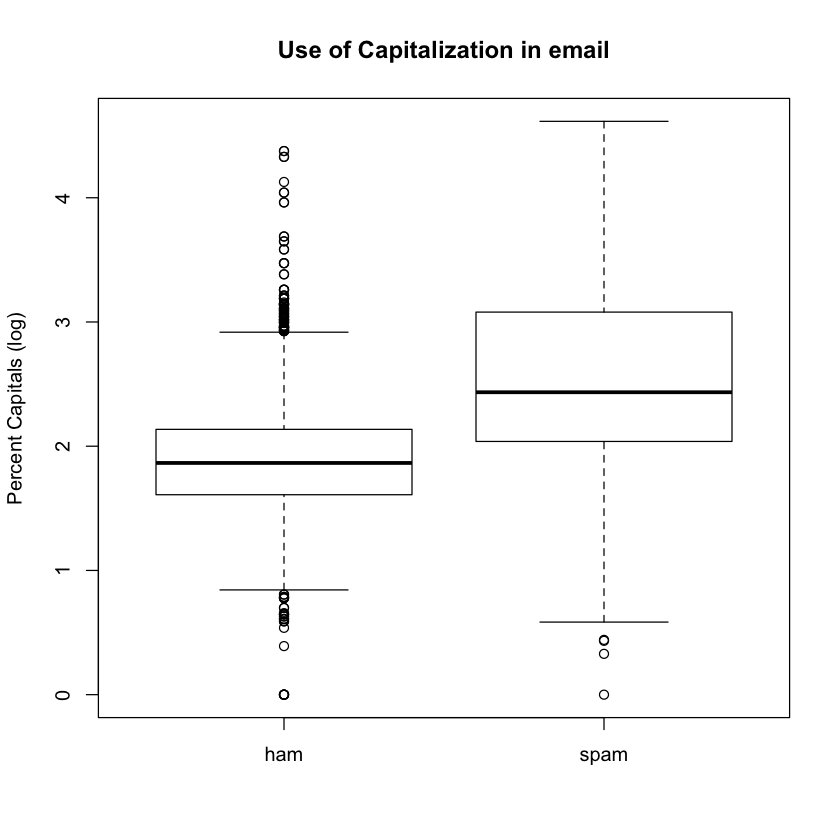

In [21]:
# show percent of capital letters in spam/ham 
# spam has more capital letters than ham

percent = emailDF$perCaps
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
boxplot(log(1 + percent) ~ isSpamLabs,
        ylab = "Percent Capitals (log)", main = "Use of Capitalization in email")

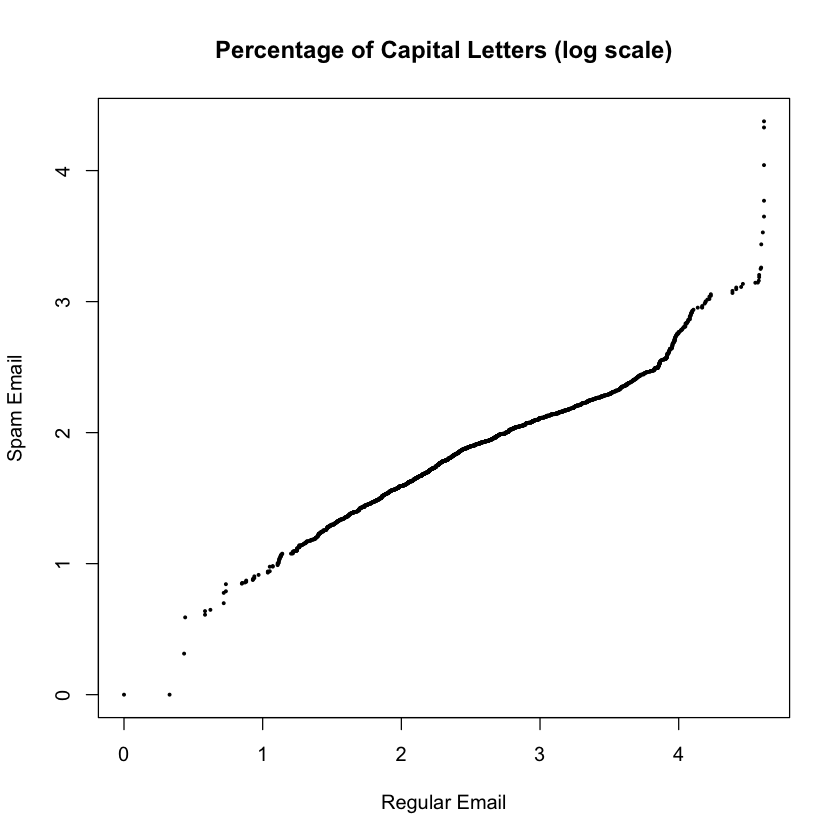

In [12]:
# spam has higher percent of capital letters than ham

logPerCapsSpam = log(1 + emailDF$perCaps[ emailDF$isSpam ])
logPerCapsHam = log(1 + emailDF$perCaps[ !emailDF$isSpam ])

qqplot(logPerCapsSpam, logPerCapsHam, 
       xlab = "Regular Email", ylab = "Spam Email", 
       main = "Percentage of Capital Letters (log scale)",
       pch = 19, cex = 0.3)

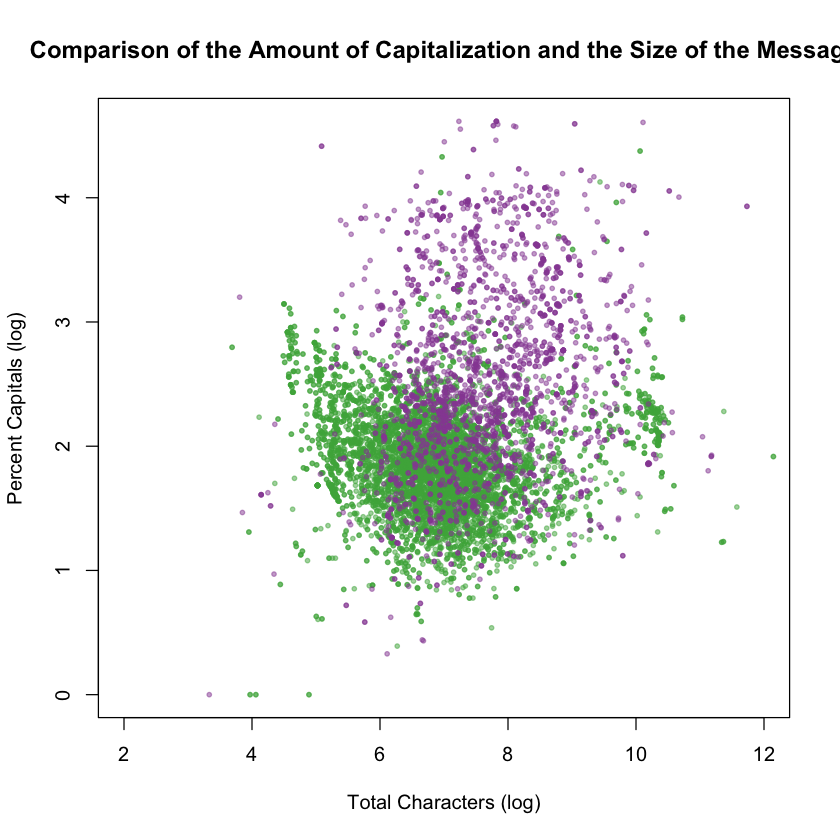

In [23]:
# percent of capital letters vs total characters

colI = c("#4DAF4A80", "#984EA380")
logBodyCharCt = log(1 + emailDF$bodyCharCt)
logPerCaps = log(1 + emailDF$perCaps)
plot(logPerCaps ~ logBodyCharCt, xlab = "Total Characters (log)",
     main = "Comparison of the Amount of Capitalization and the Size of the Message",
     ylab = "Percent Capitals (log)",
     col = colI[1 + emailDF$isSpam],
     xlim = c(2,12), pch = 19, cex = 0.5)

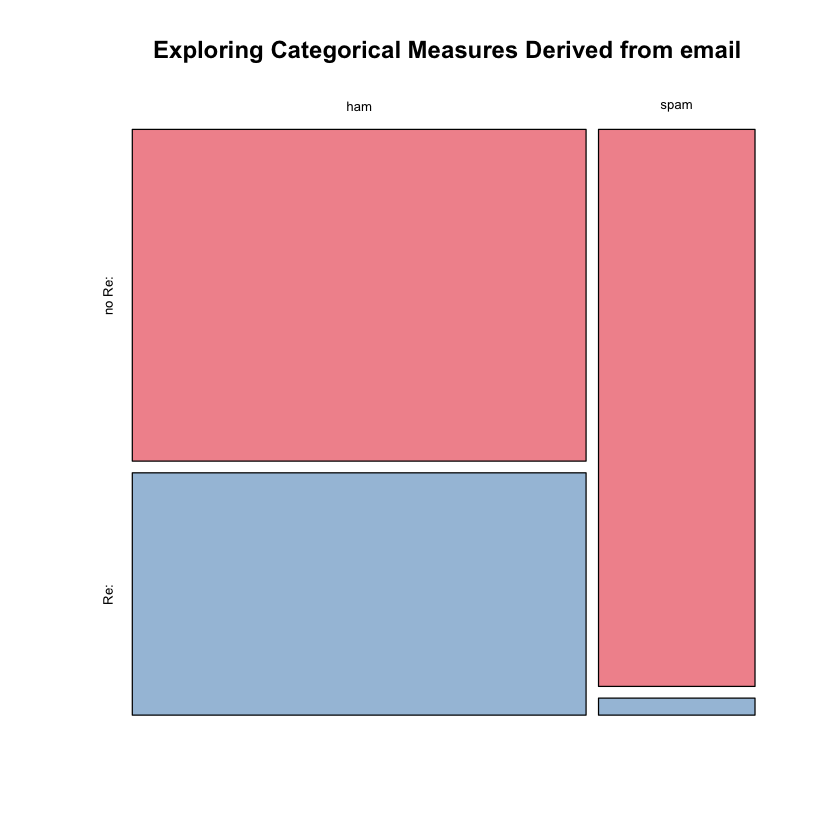

In [24]:
# "re:" occurs more in ham than in spam messages

colM = c("#E41A1C80", "#377EB880")
isRe = factor(emailDF$isRe, labels = c("no Re:", "Re:"))
mosaicplot(table(isSpamLabs, isRe), main = " Exploring Categorical Measures Derived from email",
           xlab = "", ylab = "", color = colM)

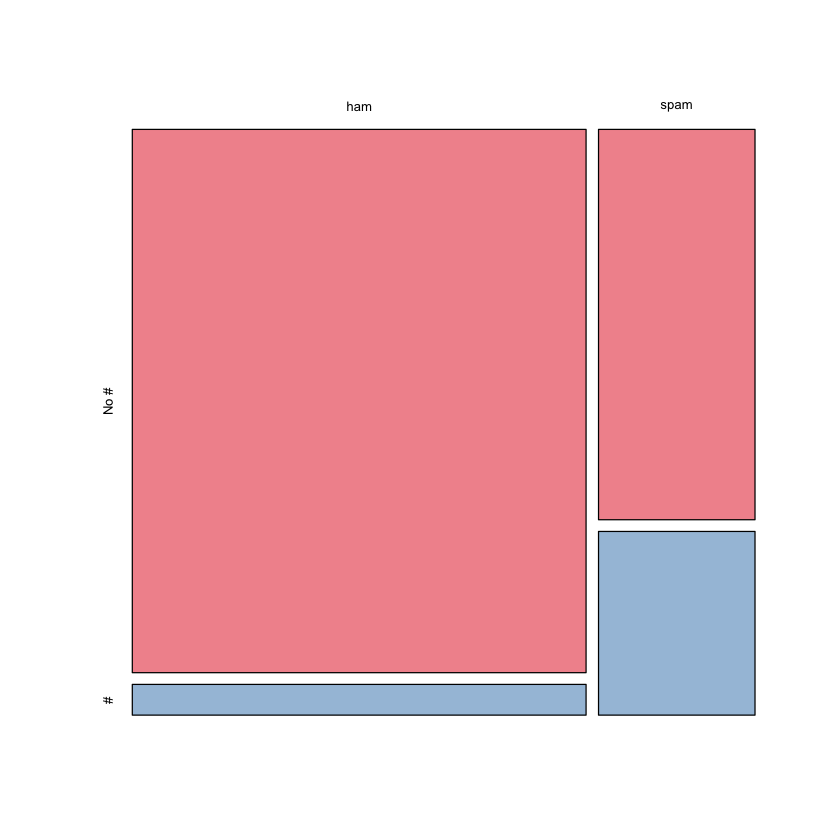

In [16]:
# sender email address has numbers at the end more often in spam than ham

fromNE = factor(emailDF$numEnd, labels = c("No #", "#"))
mosaicplot(table(isSpamLabs, fromNE), color = colM,
           main = "", xlab="", ylab = "")

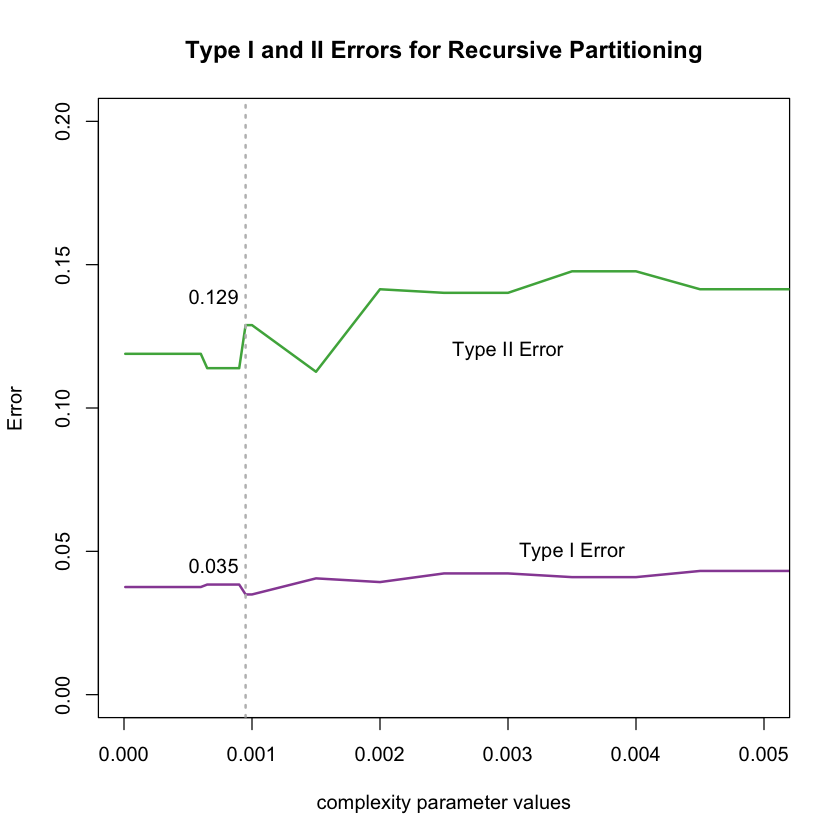

In [30]:
# optimal cp value is .001 when type 1 is 3.4% and type 2 is 13%

fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class", 
                          control = rpart.control(cp=x) )
           
         predict(rpartObj, 
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
        })

spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
                     })

library(RColorBrewer)
cols = brewer.pal(9, "Set1")[c(3, 4, 5)]
plot(errs[1,] ~ complexityVals, type="l", col=cols[2], 
     lwd = 2, ylim = c(0,0.2), xlim = c(0,0.005), 
     ylab="Error", xlab="complexity parameter values", main = "Type I and II Errors for Recursive Partitioning")
points(errs[2,] ~ complexityVals, type="l", col=cols[1], lwd = 2)

text(x =c(0.003, 0.0035), y = c(0.12, 0.05), 
     labels=c("Type II Error", "Type I Error"))

minI = which(errs[1,] == min(errs[1,]))[1]
abline(v = complexityVals[minI], col ="grey", lty =3, lwd=2)

text(0.0007, errs[1, minI]+0.01, 
     formatC(errs[1, minI], digits = 2))
text(0.0007, errs[2, minI]+0.01, 
     formatC(errs[2, minI], digits = 3))

### MODELLING

In [31]:
# Read in the spam/ham data using separate R file, clean it
source('ReadSpamData_fromBook.R', echo = FALSE)

Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'”Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'”Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'”

In [32]:
# Using 418910 as the seed, use sample function to train (67%) & test (33%) spam/ham data
# Number of unique words counted in the train data is 80,481

set.seed(418910)

testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testMsgWords = c((msgWordsList[isSpam])[testSpamIdx],
                 
                 (msgWordsList[!isSpam])[testHamIdx])

trainMsgWords = c((msgWordsList[isSpam])[ - testSpamIdx], 
                  (msgWordsList[!isSpam])[ - testHamIdx])

testIsSpam = rep(c(TRUE, FALSE), 
                 c(length(testSpamIdx), length(testHamIdx)))
trainIsSpam = rep(c(TRUE, FALSE), 
                 c(numSpam - length(testSpamIdx), 
                   numHam - length(testHamIdx)))

bow = unique(unlist(trainMsgWords))

length(bow)

spamWordCounts = rep(0, length(bow))

names(spamWordCounts) = bow

tmp = lapply(trainMsgWords[trainIsSpam], unique)
tt = table( unlist(tmp) )
spamWordCounts[ names(tt) ] = tt

[1] 79101

In [33]:
# sum of log likelihood for spam test messages matching with the 
# word bank of the spam training set: 254.693

# sum of log likelihood for ham test messages matching with the 
# word bank of the spam training set: -124.662

computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5

   # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  


   # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

trainTable = computeFreqs(trainMsgWords, trainIsSpam)

newMsg = testMsgWords[[1]]

newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]

present = colnames(trainTable) %in% newMsg

sum(trainTable["presentLogOdds", present]) + 
  sum(trainTable["absentLogOdds", !present])

newMsg = testMsgWords[[ which(!testIsSpam)[1] ]]
newMsg = newMsg[!is.na(match(newMsg, colnames(trainTable)))]
present = (colnames(trainTable) %in% newMsg)
sum(trainTable["presentLogOdds", present]) + 
     sum(trainTable["absentLogOdds", !present])

[1] 255.9993

[1] -123.3356

In [34]:
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

testLLR = sapply(testMsgWords, computeMsgLLR, trainTable)

tapply(testLLR, testIsSpam, summary)

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1359.7  -126.0  -100.2  -115.2   -80.3   701.2 

$`TRUE`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  -59.638     6.935    50.759   136.244   128.592 23208.822 


In [35]:
typeIErrorRate = 
function(tau, llrVals, spam)
{
  classify = llrVals > tau
  sum(classify & !spam)/sum(!spam)
}

typeIErrorRate(0, testLLR,testIsSpam)

typeIErrorRate(-20, testLLR,testIsSpam)

typeIErrorRates = 
function(llrVals, isSpam) 
{
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]

  idx = which(!isSpam)
  N = length(idx)
  list(error = (N:1)/N, values = llrVals[idx])
}

typeIIErrorRates = function(llrVals, isSpam) {
    
  o = order(llrVals)
  llrVals =  llrVals[o]
  isSpam = isSpam[o]
    
    
  idx = which(isSpam)
  N = length(idx)
  list(error = (1:(N))/N, values = llrVals[idx])
  }  

xI = typeIErrorRates(testLLR, testIsSpam)
xII = typeIIErrorRates(testLLR, testIsSpam)
tau01 = round(min(xI$values[xI$error <= 0.01]))
tau01 # tau optimized at -43

t1 = max(xI$error[ xI$values > tau01 ])
t1 # type 1 error minimized at .009495
t2 = max(xII$error[ xII$values < tau01 ])
t2 # type 2 error minimized at .022025

[1] 0.003452741

[1] 0.006042296

[1] -42

[1] 0.01035822

[1] 0.02252816

In [36]:
# split into 5 folds? this part was in the book code but not sure what it is doing

k = 5
numTrain = length(trainMsgWords)
partK = sample(numTrain)
tot = k * floor(numTrain/k)
partK = matrix(partK[1:tot], ncol = k)

testFoldOdds = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  trainTabFold = computeFreqs(trainMsgWords[-foldIdx], trainIsSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(trainMsgWords[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, trainIsSpam[foldIdx])
}

xFoldI = typeIErrorRates(testFoldOdds, testFoldSpam)
xFoldII = typeIIErrorRates(testFoldOdds, testFoldSpam)
tauFoldI = round(min(xFoldI$values[xFoldI$error <= 0.01]))
tFold2 = xFoldII$error[ xFoldII$values < tauFoldI ]

In [9]:
# use separate R file to split up header, body, attachments
# finds percentage of capital letters and character frequencies, etc
source('FeatureCreation_fromBook.R', echo = FALSE)

[1] 1.8189894035458564758e-06
[1] 10000.000001818989404
[1] 10000


Warning message in grep(bString, body):
“input string 41 is invalid in this locale”Warning message in grep(bString, body):
“input string 43 is invalid in this locale”Warning message in grep(bString, body):
“input string 51 is invalid in this locale”Warning message in grep(eString, body):
“input string 41 is invalid in this locale”Warning message in grep(eString, body):
“input string 43 is invalid in this locale”Warning message in grep(eString, body):
“input string 51 is invalid in this locale”Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'”Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'”Warning message in FUN(X[[i]], ...):
“incomplete final line found on './spam/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'”Warning message in indNA == indNoSubject:
“longer object length is not a multiple of shorter object

In [11]:
# table that shows the # of attachments for spam/ham
# doesn't seem to be a good indicator
isSpamLabs = factor(emailDF$isSpam, labels = c("ham", "spam"))
table(emailDF$numAtt, isSpamLabs)
oldPar = par(mfrow = c(1, 2), mar = c(1,1,1,1))

    isSpamLabs
      ham spam
  0  6624 2158
  1   314  230
  2    11    6
  4     0    1
  5     1    2
  18    1    0

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: rpart


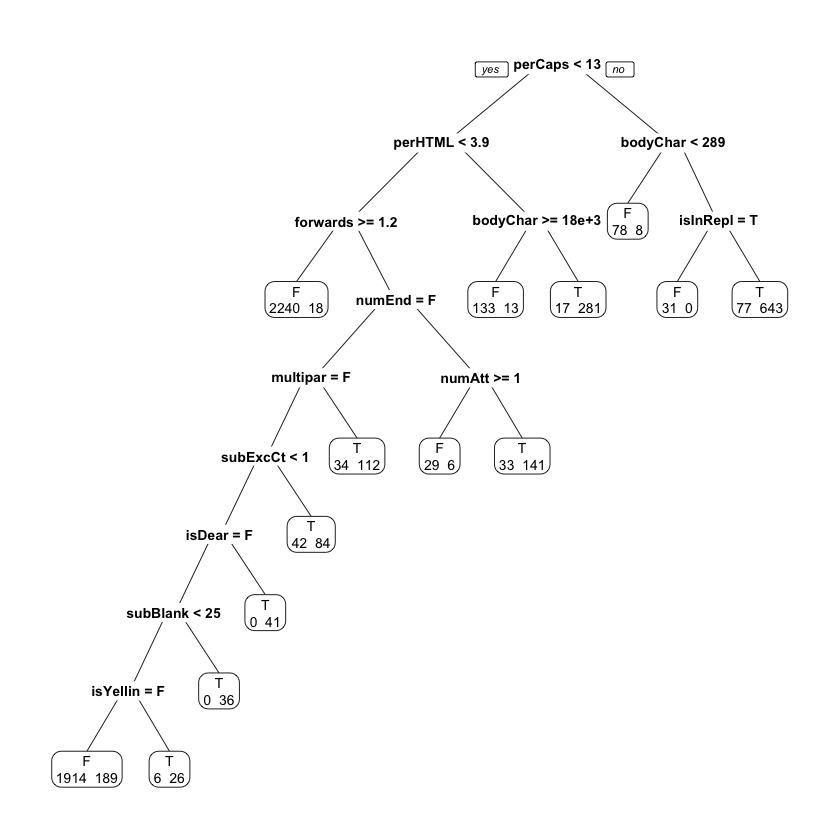

In [13]:
# wow beautiful decision tree

install.packages("rpart.plot")
library(rpart.plot)
setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)


set.seed(418910)
testSpamIdx = sample(numSpam, size = floor(numSpam/3))
testHamIdx = sample(numHam, size = floor(numHam/3))

testDF = 
  rbind( emailDFrp[ emailDFrp$isSpam == "T", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "F", ][testHamIdx, ] )
trainDF =
  rbind( emailDFrp[emailDFrp$isSpam == "T", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "F", ][-testHamIdx, ])

rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")
prp(rpartFit, extra = 1)

In [14]:
# the beautiful decision tree had 2192 true positives. 125 false negatives.

predictions = predict(rpartFit, 
       newdata = testDF[, names(testDF) != "isSpam"],
       type = "class")
 
predsForHam = predictions[ testDF$isSpam == "F" ]
summary(predsForHam)

F    T 
2192  125

In [15]:
getIsSpamFolds <- function() {
    isSpam = list()
    for (i in 1:length(fold_indices)) {
        current_name = fold_indices[i]
        otherNames = fold_indices[fold_indices != current_name]

        test_indices = unlist(folds[current_name])
        train_indices = unlist(folds[otherNames])
        
        trainIsSpam_local = trainIsSpam[train_indices]

        isSpam[[i]] = trainIsSpam_local
    }
    
    return(unlist(isSpam))
}